In [1]:
import os
import pandas as pd
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

import missingno as msno

from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, RandomizedSearchCV

from sklearn.metrics import auc, roc_curve, roc_auc_score, classification_report, confusion_matrix, accuracy_score 

from sklearn.utils.class_weight import compute_sample_weight



import numpy as np
import matplotlib.pyplot as plt
import sage 

import xgboost as xgb

/home/jlm217/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.chdir('/home/jlm217/rds/rds-mrc-bsu-csoP2nj6Y6Y/mimah/stopah/stopah/data') 

pd.set_option('display.max_columns', None)  

ro.r['load']('STOPAH_ForSolon.RData')

def R_dataset(x):
    with (ro.default_converter + pandas2ri.converter).context():
        stopah = ro.conversion.get_conversion().rpy2py(ro.r[x])
    return stopah

stopah = R_dataset('stopah')

R[write to console]: Warning:
R[write to console]:  namespace ‘pROC’ is not available and has been replaced
by .GlobalEnv when processing object ‘roc.objs’



In [3]:
selected = ['D28_DTH','D90_DTH','Prednisolone']

baseline = ['Gender','Baseline_sepsis','Baseline_GIB',
'Age.at.randomisation..calc.','Weight','Max.grams.of.alcohol.drunk.per.day..calc.','Hepatic.Encephalopathy...Merged',
'Temperature...Merged','Pulse...Merged','Systolic.BP...Merged','Diastolic.BP...Merged','MAP','Hb...Merged','Platelets...Merged',
'WBC...Merged','Neutrophils...Merged','INR...Merged.clinical.and.calc','Bilirubin.Merged','ALT...Merged','ALP...Merged',
'Albumin...Merged','Sodium...Merged','Potassium...Merged','Urea...Merged','Creatinine...Merged','NLR_0','bDNA',
'Ferritin_ngml','Iron_mumoll','Transferrin','TSAT','PNPLA3_Add','PNPLA3_Rec','HPCT_NG'] 

sevenday = ['Hepatic.Encephalopathy...Treatment.Day.7..',
'Day.7.infection',
'Gastrointestinal.Bleed.since.the.last.visit.Gastrointestinal.bleed...and.Choose..Treatment.Day.7..',
'Temperature..Treatment.Day.7..',
'Pulse..Treatment.Day.7..',
'Systolic.BP..Treatment.Day.7..',
'Diastolic.BP..Treatment.Day.7..',
'MAP..Treatment.Day.7',
'Hb..1.decimal.point..Haematology..Treatment.Day.7..',
'Platelets.day.7',
'WBC.day.7',
'Neutrophils.day.7',
'INR.clinical.and.calc.day.7',
'Bilirubin.day.7',
'ALT.day.7',
'ALP.day.7',
'Albumin.day.7',
'Sodium.day.7',
'Potassium.day.7',
'Urea.day.7',
'Creatinine.day.7']

#reduce data set to target, treatment and therapy

stopah = stopah[sevenday+['Prednisolone','D28_DTH']]

stopah.reset_index(drop=True, inplace=True)

In [4]:
df = stopah.dropna()

#Untreated
df0 = df[df['Prednisolone']==0].drop(['Prednisolone'],axis=1)

X0, y0 = df0.drop('D28_DTH', axis=1), df0[['D28_DTH']]


#Treated
df = df[df['Prednisolone']==1].drop(['Prednisolone'],axis=1)

X, y = df.drop('D28_DTH', axis=1), df[['D28_DTH']]



In [5]:
cats = ['Hepatic.Encephalopathy...Treatment.Day.7..', 'Day.7.infection',
              'Gastrointestinal.Bleed.since.the.last.visit.Gastrointestinal.bleed...and.Choose..Treatment.Day.7..']

#for col in cats:
 #   X[col] = X[col].astype('category')

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1,test_size=0.25)

X0_train, X0_test, y0_train, y0_test = train_test_split(X0, y0, random_state=1,test_size=0.25)

### Treated

In [21]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.5,max_depth=7,random_state=0).fit(X_train, y_train)

/home/jlm217/.local/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [22]:
clf.score(X_test, y_test)

0.8266666666666667

In [23]:
y_predict = clf.predict_proba(X_test)

In [24]:
auc_score = roc_auc_score(y_test, y_predict[:,1])
print('AUC Score:',(auc_score)*100)

AUC Score: 85.44444444444444


<Axes: >

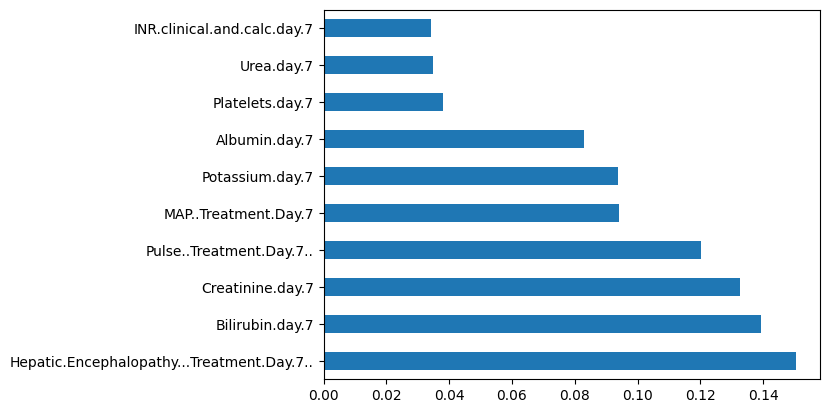

In [41]:
feat_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')

### Untreated

In [25]:
clf0 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=8, random_state=0).fit(X0_train, y0_train)

/home/jlm217/.local/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [26]:
clf.score(X0_test, y0_test)

0.7906976744186046

In [27]:
y0_predict = clf.predict_proba(X0_test)

In [28]:
auc_score = roc_auc_score(y0_test, y0_predict[:,1])
print('AUC Score:',(auc_score)*100)

AUC Score: 73.16468253968253


<Axes: >

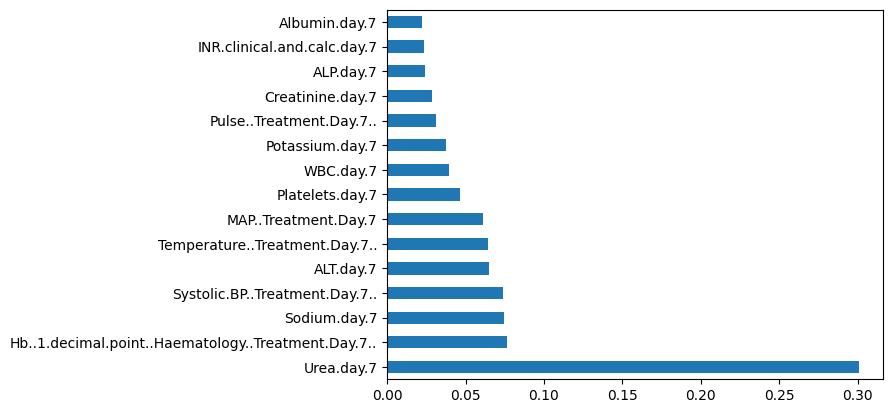

In [42]:
feat_importances = pd.Series(clf0.feature_importances_, index=X0_train.columns)
feat_importances.nlargest(15).plot(kind='barh')